In [1]:
import seaborn as sns
import pandas as pd
from pathlib import Path
from utils import *
from resnet import create_resnet
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import fastai
from fastai.vision import *

In [2]:
DATAPATH = Path.cwd()/'Univariate_arff'

In [3]:
sorted(list(DATAPATH.iterdir()))

[PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/ACSF1'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/Adiac'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/AllGestureWiimoteX'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/AllGestureWiimoteY'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/AllGestureWiimoteZ'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/ArrowHead'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/BME'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/Beef'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/BeetleFly'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/BirdChicken'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/CBF'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/C

In [4]:
task = 'Adiac'
df_train, df_test = load_df(DATAPATH, task)

In [5]:
num_classes = df_train.target.nunique(); num_classes

37

In [6]:
def process_dfs(df_train, df_test):
    x_train, y_train = df_train.values[:,:-1].astype('float'), df_train.values[:,-1].astype('int')
    x_test, y_test = df_test.values[:,:-1].astype('float'), df_test.values[:,-1].astype('int')

    x_train_mean = x_train.mean()
    x_train_std = x_train.std()

    x_train = (x_train - x_train_mean)/(x_train_std)
    x_test = (x_test - x_train_mean)/(x_train_std)

    y_train = (y_train - y_train.min())/(y_train.max()-y_train.min())*(num_classes-1)
    y_test = (y_test - y_test.min())/(y_test.max()-y_test.min())*(num_classes-1)
    return x_train, y_train, x_test, y_test

# DL

In [7]:
def to_TDS(x, y):
    return TensorDataset(torch.Tensor(x).unsqueeze(dim=1),  torch.Tensor(y).long())

def create_databunch(tr_ds, val_ds, bs=64):
    train_dl = DataLoader(tr_ds, batch_size=bs, shuffle=True)
    valid_dl = DataLoader(val_ds, batch_size=bs, shuffle=True)
    return DataBunch(train_dl, valid_dl)

In [8]:
x_train, y_train, x_test, y_test = process_dfs(df_train, df_test)

In [10]:
x_train.shape, x_test.shape

((390, 176), (391, 176))

In [11]:
tr_ds, val_ds = to_TDS(x_train, y_train), to_TDS(x_test, y_test)

In [12]:
db = create_databunch(tr_ds, val_ds, 64)

Testing dims at input/output

In [13]:
tx, ty = next(iter(db.train_dl))

In [14]:
tx.shape, ty.shape

(torch.Size([64, 1, 176]), torch.Size([64]))

## Resnet 1D

In [15]:
model = create_resnet(1, num_classes); model

Sequential(
  (0): Sequential(
    (0): Conv1d(1, 64, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): SequentialEx(
    (layers): ModuleList(
      (0): Sequential(
        (0): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
        (1): ReLU(inplace=True)
        (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): Sequential(
        (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (1): ReLU(inplace=True)
        (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): MergeLayer()
    )
  )
  (2): Sequential(
    (0): Conv1d(64, 128, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [16]:
learn_res = fastai.basic_train.Learner(db, 
                                       model, 
                                       loss_func = CrossEntropyFlat(), 
                                       metrics=[error_rate],
                                       wd=1e-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


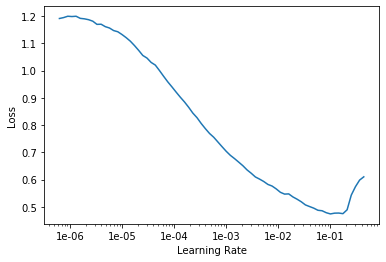

In [17]:
learn_res.lr_find(); learn_res.recorder.plot()

In [18]:
learn_res.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.512832,0.894321,0.565444,00:01
1,0.330662,0.459436,0.150194,00:01
2,0.266749,0.305511,0.145580,00:01
3,0.226188,0.275346,0.116076,00:01
4,0.192768,0.122676,0.025498,00:01
5,0.171055,0.135361,0.040675,00:01
6,0.146778,0.106762,0.029019,00:01
7,0.124685,0.102081,0.030840,00:01
8,0.110319,0.099244,0.028169,00:01
9,0.097802,0.094529,0.025983,00:01


In [19]:
p, t = learn_res.get_preds()

In [20]:
error_rate(p,t)

tensor(0.0260)

In [22]:
def get_cm(p, t): return confusion_matrix(t, p.softmax(dim=1).argmax(1))

Confusion Matrix

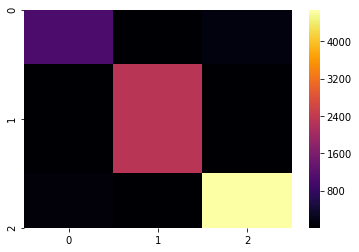

In [23]:
sns.heatmap(get_cm(p,t), cmap='inferno')